In [2]:
import os
import pandas as pd
import torch
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random

from transformers import CLIPProcessor, CLIPModel, AutoProcessor
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# Load CLIP model and processor
model_name = "openai/clip-vit-large-patch14"
processor = AutoProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

# Embed Dataset

In [91]:
def get_image_embeddings(images):
    inputs = processor(images=images, return_tensors="pt", padding=True)
    inputs = inputs.to(device)
    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=inputs['pixel_values']) # Get the class token embedding 
    return image_features  

In [187]:
def compute_image_embeddings(dataset_name='CLEVR', batch_size=100, only_train=True):
    """Computes image embeddings, centers, and normalizes them."""
    metadata = pd.read_csv(f'Data/{dataset_name}/metadata.csv')
    if only_train:
        metadata = metadata[metadata['split'] == 'train']
    image_paths = metadata['image_path'].tolist()

    # Load images
    print("Loading images...")
    images = []
    for image_filename in tqdm(image_paths):
        image = Image.open(f'Data/{dataset_name}/{image_filename}').convert("RGB")
        image_tensor = torch.tensor(np.array(image).transpose((2, 0, 1)))  # Convert image to (C, H, W)
        images.append(image_tensor)
    
    print(f"Loaded {len(images)} images.")

    # Embed images in batches
    print("Computing embeddings in batches...")
    embeddings = []
    n_batches = (len(images) + batch_size - 1) // batch_size  # Calculate number of batches
    for i in tqdm(range(n_batches)):
        batch_images = images[i * batch_size:(i + 1) * batch_size]
        batch_embeddings = get_image_embeddings(batch_images)  # Replace with your actual embedding function
        embeddings.append(batch_embeddings)
    
    embeddings = torch.cat(embeddings, dim=0).cpu()  # Concatenate all batch embeddings
    print(f"Extracted embeddings of shape: {embeddings.shape}")

    # Center embeddings
    print("Centering embeddings...")
    mean_embedding = embeddings.mean(dim=0)
    centered_embeddings = embeddings - mean_embedding
    
    # Normalize embeddings
    norm_embeddings = centered_embeddings / centered_embeddings.norm(dim=0, keepdim=True)

    # Save only the normalized embeddings to a tensor file
    if only_train:
        output_tensor_file = f'Experiments/Embeddings/{dataset_name}/train_embeddings.pt'
    else:
        output_tensor_file = f'Experiments/Embeddings/{dataset_name}/embeddings.pt'
    torch.save(norm_embeddings, output_tensor_file)
    print(f"Normalized embeddings saved to {output_tensor_file} :)")
compute_image_embeddings(dataset_name='CUB')

Loading images...


100%|██████████| 7165/7165 [01:41<00:00, 70.29it/s]


Loaded 7165 images.
Computing embeddings in batches...


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


Extracted embeddings of shape: torch.Size([7165, 768])
Centering embeddings...
Normalized embeddings saved to Experiments/Embeddings/CUB/train_embeddings.pt :)


# Compute Concepts

In [200]:
def compute_concepts(dataset_name='CLEVR', only_train=True):
    """Computes concept vectors for each concept and saves them in a file."""
    output_dir = f'Experiments/Concepts/{dataset_name}'

    # Load the embeddings and metadata
    metadata_df = pd.read_csv(f'Data/{dataset_name}/metadata.csv')
    if only_train:
        embeddings = torch.load(f'Experiments/Embeddings/{dataset_name}/train_embeddings.pt')
        metadata_df = metadata_df[metadata_df['split'] == 'train']
    else:
        embeddings = torch.load(f'Experiments/Embeddings/{dataset_name}/embeddings.pt')

    # Infer concept columns (exclude 'image_path', 'class', and 'split')
    concept_columns = [col for col in metadata_df.columns if col not in ['image_path', 'class', 'split']]
    print(f"Inferred concept columns: {concept_columns}")
    
    # Dictionary to store all concept embeddings (merged across all concepts)
    all_concept_embeddings = {}

    # Iterate through each concept column
    for concept in tqdm(concept_columns):
        # Create a dictionary to store the embeddings for each concept value
        concept_embeddings = {}

        # Iterate through each image, its embedding, and the corresponding concept value
        for idx, embedding in enumerate(embeddings):
            concept_value = metadata_df.iloc[idx].loc[concept]
            
            # If the concept is present (binary check), add the embedding to the dictionary
            if concept_value == 1:
                concept_key = f'{concept}'  # This will be in the format 'concepttype::conceptkey'
                if concept_key not in concept_embeddings:
                    concept_embeddings[concept_key] = []
                concept_embeddings[concept_key].append(embedding)

        # Calculate the average embedding for each concept value
        for value, group_embeddings in concept_embeddings.items():
            group_embeddings = torch.stack(group_embeddings)  # Convert to tensor
            avg_embedding = group_embeddings.mean(dim=0)  # Calculate the average embedding
            avg_embedding = avg_embedding / avg_embedding.norm()  # Normalize the average embedding
            
            # Store the computed embedding
            all_concept_embeddings[value] = avg_embedding

    # Save **all concept embeddings** in a single file
    if only_train:
        output_file = os.path.join(output_dir, 'train_concepts.pt')
    else:
        output_file = os.path.join(output_dir, 'concepts.pt')
    torch.save(all_concept_embeddings, output_file)
    print(f"All concept embeddings saved at {output_file} :)")

# Example usage:
compute_concepts(dataset_name='CUB')

Inferred concept columns: ['has_back_color::black', 'has_back_color::blue', 'has_back_color::brown', 'has_back_color::buff', 'has_back_color::green', 'has_back_color::grey', 'has_back_color::iridescent', 'has_back_color::olive', 'has_back_color::orange', 'has_back_color::pink', 'has_back_color::purple', 'has_back_color::red', 'has_back_color::rufous', 'has_back_color::white', 'has_back_color::yellow', 'has_back_pattern::multi-colored', 'has_back_pattern::solid', 'has_back_pattern::spotted', 'has_back_pattern::striped', 'has_belly_color::black', 'has_belly_color::blue', 'has_belly_color::brown', 'has_belly_color::buff', 'has_belly_color::green', 'has_belly_color::grey', 'has_belly_color::iridescent', 'has_belly_color::olive', 'has_belly_color::orange', 'has_belly_color::pink', 'has_belly_color::purple', 'has_belly_color::red', 'has_belly_color::rufous', 'has_belly_color::white', 'has_belly_color::yellow', 'has_belly_pattern::multi-colored', 'has_belly_pattern::solid', 'has_belly_pattern

100%|██████████| 312/312 [04:31<00:00,  1.15it/s]

All concept embeddings saved at Experiments/Concepts/CUB/train_concepts.pt :)


# Visualize Concepts

## Compute Cosine Similarities Between Images and Concepts

In [41]:
def compute_cosine_sims(dataset_name='CLEVR', batch_size=32, only_train=True):
    """Compute cosine similarity between each image embedding and each concept."""
    
    # Load the image and concept embeddings
    #always compute cosine similarity using all embeddings
    embeddings = torch.load(f'../Experiments/Embeddings/{dataset_name}/embeddings.pt') 
    if only_train:
        all_concept_embeddings = torch.load(f'../Experiments/Concepts/{dataset_name}/train_concepts.pt')
    else:
        all_concept_embeddings = torch.load(f'../Experiments/Concepts/{dataset_name}/concepts.pt')

    # Move embeddings and concept embeddings to GPU (if not already on GPU)
    embeddings = embeddings.to('cuda') if not embeddings.is_cuda else embeddings
    all_concept_embeddings = {k: v.to('cuda') if not v.is_cuda else v for k, v in all_concept_embeddings.items()}
    
    # Convert concept embeddings to a tensor (batch of all concept embeddings)
    all_concept_embeddings_tensor = torch.stack(list(all_concept_embeddings.values())).to('cuda')

    # Initialize a list to store cosine similarity rows
    cosine_similarity_rows = []

    # Compute cosine similarity in batches
    n_images = embeddings.shape[0]
    for i in tqdm(range(0, n_images, batch_size)):
        # Get a batch of image embeddings
        batch_embeddings = embeddings[i:i+batch_size]
        
        # Compute cosine similarity for the batch
        cosine_similarities = F.cosine_similarity(batch_embeddings.unsqueeze(1), all_concept_embeddings_tensor.unsqueeze(0), dim=2)

        # Convert each batch's similarity results into rows
        for image_cosine_similarities in cosine_similarities:
            cosine_similarity_row = {
                concept_value: image_cosine_similarities[i].item()
                for i, concept_value in enumerate(all_concept_embeddings.keys())
            }
            cosine_similarity_rows.append(cosine_similarity_row)
        
        # Free memory for the next batch
        del batch_embeddings, cosine_similarities
        torch.cuda.empty_cache()

    # Create a DataFrame where each column corresponds to a concept-value combination
    cosine_similarity_df = pd.DataFrame(cosine_similarity_rows)

    # Save the cosine similarity results to a CSV file
    if only_train:
        output_file = f'../Experiments/Cosine_Similarities/{dataset_name}/train_cosine_similarities.csv'
    else:
        output_file = f'../Experiments/Cosine_Similarities/{dataset_name}/cosine_similarities.csv'
    cosine_similarity_df.to_csv(output_file, index=False)

    print(f"Cosine similarity results for all concepts saved at {output_file} :)")

# Example usage:
compute_cosine_sims(dataset_name='CUB')

100%|██████████| 369/369 [00:45<00:00,  8.13it/s]


Cosine similarity results for all concepts saved at ../Experiments/Cosine_Similarities/CUB/train_cosine_similarities.csv :)


## Plot most activated images for a chosen concept

Available concept categories:
1. has_back_color
2. has_back_pattern
3. has_belly_color
4. has_belly_pattern
5. has_bill_color
6. has_bill_length
7. has_bill_shape
8. has_breast_color
9. has_breast_pattern
10. has_crown_color
11. has_eye_color
12. has_forehead_color
13. has_head_pattern
14. has_leg_color
15. has_nape_color
16. has_primary_color
17. has_shape
18. has_size
19. has_tail_pattern
20. has_tail_shape
21. has_throat_color
22. has_under_tail_color
23. has_underparts_color
24. has_upper_tail_color
25. has_upperparts_color
26. has_wing_color
27. has_wing_pattern
28. has_wing_shape


Enter the number of the concept category you want to choose (1-28):  1



Available concepts in category 'has_back_color':
1. black
2. blue
3. brown
4. buff
5. green
6. grey
7. iridescent
8. olive
9. orange
10. pink
11. purple
12. red
13. rufous
14. white
15. yellow


Enter the number of the specific concept you want to choose (1-15):  1


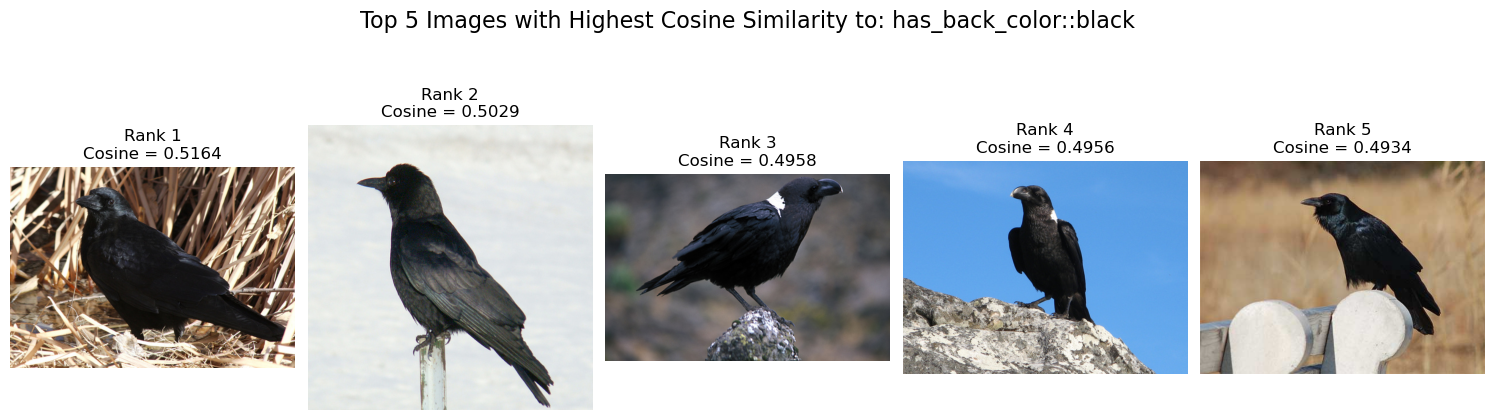

In [233]:
def get_user_category(concept_columns):
    """Helper function to get the user's choice for concept category"""
    print("Available concept categories:")
    categories = sorted(set(col.split('::')[0] for col in concept_columns))  # Get unique concept categories
    for idx, category in enumerate(categories):
        print(f"{idx + 1}. {category}")
    
    while True:
        try:
            choice = int(input(f"Enter the number of the concept category you want to choose (1-{len(categories)}): "))
            if 1 <= choice <= len(categories):
                return categories[choice - 1], concept_columns
            else:
                print("Invalid choice, please select a number from the list.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_user_concept(category, concept_columns):
    """Helper function to get the user's choice for specific concept within a category"""
    # Filter concepts based on selected category
    concepts = [col for col in concept_columns if col.startswith(category)]
    print(f"\nAvailable concepts in category '{category}':")
    for idx, concept in enumerate(concepts):
        print(f"{idx + 1}. {concept.split('::')[1]}")  # Display the specific concept (e.g., 'red', 'cube', etc.)
    
    while True:
        try:
            choice = int(input(f"Enter the number of the specific concept you want to choose (1-{len(concepts)}): "))
            if 1 <= choice <= len(concepts):
                return concepts[choice - 1]
            else:
                print("Invalid choice, please select a number from the list.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def plot_aligned_images(k=5, dataset_name='CLEVR', only_train=True):
    """ Plot k images most aligned with a user chosen concept from the given dataset """
    
    # Load the cosine similarity results
    metadata_df = pd.read_csv(f'Data/{dataset_name}/metadata.csv')
    if only_train:
        cosine_df = pd.read_csv(f'Experiments/Cosine_Similarities/{dataset_name}/train_cosine_similarities.csv')
        metadata_df = metadata_df[metadata_df['split'] == 'train']
    else:
        cosine_df = pd.read_csv(f'Experiments/Cosine_Similarities/{dataset_name}/cosine_similarities.csv')
    
    # Get the user's choice of concept category and specific concept
    concept_columns = list(cosine_df.columns)
    category, concept_columns = get_user_category(concept_columns)  # Get the category first
    concept_key = get_user_concept(category, concept_columns)  # Then get the specific concept
    
    # Sort by cosine similarity and get the top k highest values for the specified concept
    top_k_indices = cosine_df.nlargest(k, concept_key).index.tolist()
    
    # Calculate the number of rows and columns for the plot
    n_cols = min(k, 5)  # Up to 5 images per row
    n_rows = (k + 4) // 5  # Calculate number of rows needed

    # Plot the top k images based on cosine similarity
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes array to easily index it

    plt.suptitle(f"Top {k} Images with Highest Cosine Similarity to: {concept_key}", fontsize=16)
    for rank, idx in enumerate(top_k_indices):
        if rank >= len(axes):  # In case there are fewer images than axes
            break
        
        # Get the image path from metadata
        image_filename = metadata_df.iloc[idx].loc['image_path']
        img = Image.open(f'Data/{dataset_name}/{image_filename}').convert("RGB")

        cos_value = cosine_df.loc[idx, concept_key]
        axes[rank].imshow(img)
        axes[rank].set_title(f"Rank {rank+1}\nCosine = {cos_value:.4f}")
        axes[rank].axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.3) 
    plt.tight_layout(pad=0.9, h_pad=0.2)
    plt.show()

# Example usage:
plot_aligned_images(dataset_name='CUB')

## Plot heatmap showing similarities among concepts

Available concept categories:
1. has_back_color
2. has_back_pattern
3. has_belly_color
4. has_belly_pattern
5. has_bill_color
6. has_bill_length
7. has_bill_shape
8. has_breast_color
9. has_breast_pattern
10. has_crown_color
11. has_eye_color
12. has_forehead_color
13. has_head_pattern
14. has_leg_color
15. has_nape_color
16. has_primary_color
17. has_shape
18. has_size
19. has_tail_pattern
20. has_tail_shape
21. has_throat_color
22. has_under_tail_color
23. has_underparts_color
24. has_upper_tail_color
25. has_upperparts_color
26. has_wing_color
27. has_wing_pattern
28. has_wing_shape


Enter the number of the concept category you want to choose (1-28):  27


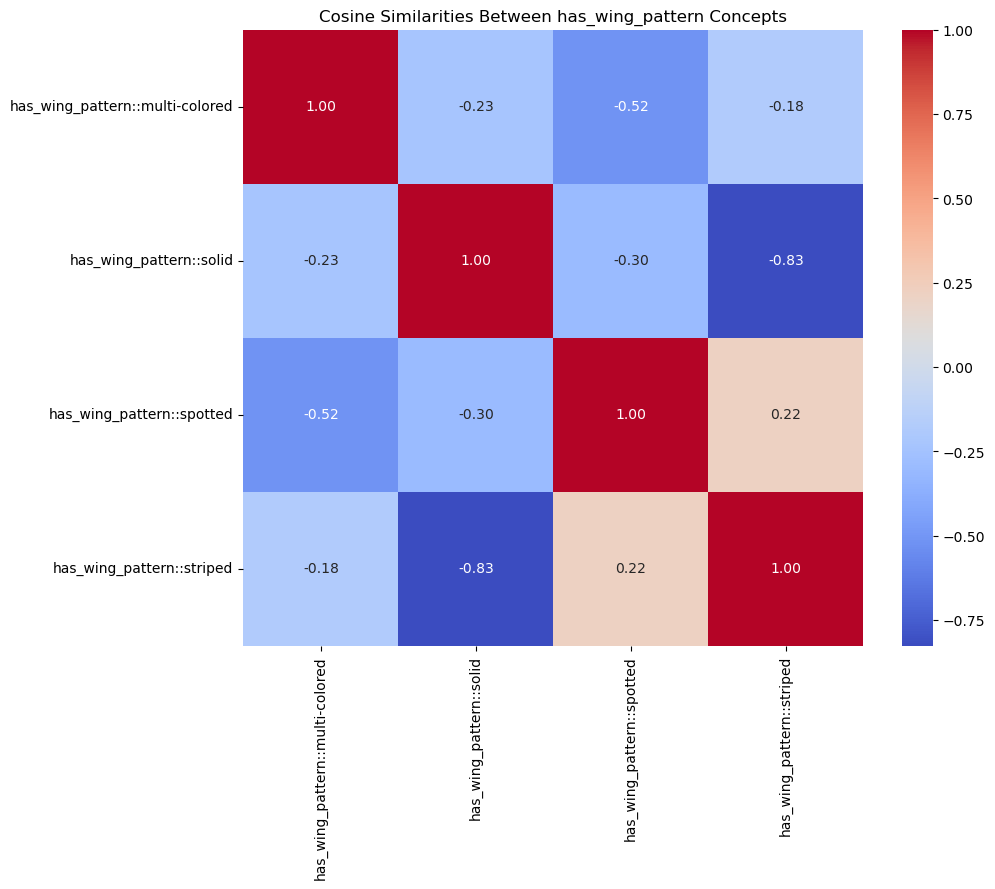

In [209]:
def create_heatmap(concept_names, cosine_similarity_matrix, heatmap_title):
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_similarity_matrix, 
                xticklabels=concept_names, 
                yticklabels=concept_names, 
                cmap='coolwarm', 
                cbar=True, 
                annot=True, 
                fmt=".2f")

    plt.title(heatmap_title)
    plt.show()

def concept_heatmap(dataset_name='CLEVR', only_train=True):
    """
    Plots a heatmap of cosine similarities between concept embeddings.

    """
    if only_train:
        concept_embeddings = torch.load(f'Experiments/Concepts/{dataset_name}/train_concepts.pt')
    else:
        concept_embeddings = torch.load(f'Experiments/Concepts/{dataset_name}/concepts.pt')
    
    #sample 10 concepts for visualization purposes
    if len(list(concept_embeddings.keys())) > 10:
        print("Sampling 10 concepts for visualization purposes")
    concept_names = random.sample(list(concept_embeddings.keys()), min(10, len(concept_embeddings)))
    concept_names.sort()
    
    # Get concept names and embeddings
    embeddings = torch.stack([concept_embeddings[name] for name in concept_names])
    
    cosine_similarity_matrix = torch.matmul(embeddings, embeddings.T).cpu().numpy()
    create_heatmap(concept_names, cosine_similarity_matrix, 'Cosine Similarity Between Concept Embeddings')


def concept_heatmap_groupedby_concept(dataset_name='CLEVR', only_train=True):
    if only_train:
        concept_embeddings = torch.load(f'Experiments/Concepts/{dataset_name}/train_concepts.pt')
    else:
        concept_embeddings = torch.load(f'Experiments/Concepts/{dataset_name}/concepts.pt')
    
    #have user choose concept category
    potential_concept_categories = [key for key in concept_embeddings.keys() if key not in ['class', 'image_filename', 'split']]
    concept_category = get_user_category(potential_concept_categories)[0]
    
    #make heatmap just based on those categories
    concept_names = [key for key in list(concept_embeddings.keys()) if key.startswith(concept_category)]
    embeddings = torch.stack([concept_embeddings[name] for name in concept_names])
    
    cosine_similarity_matrix = torch.matmul(embeddings, embeddings.T).cpu().numpy()
    create_heatmap(concept_names, cosine_similarity_matrix, f'Cosine Similarities Between {concept_category} Concepts')   

#concept_heatmap(dataset_name='CLEVR') 
concept_heatmap_groupedby_concept(dataset_name='CUB') 

Available concept categories:
1. color
2. material
3. shape
4. size


Enter the number of the concept category you want to choose (1-4):  1


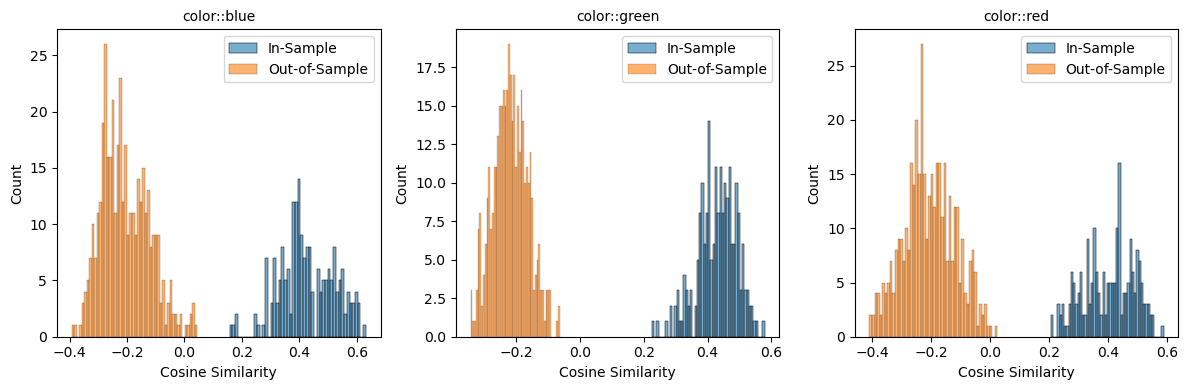

In [232]:
def plot_cosine_similarity_histogram(dataset_name='CLEVR', bins=50, images_per_row=3, only_train=True):
    """
    Plots a histogram of cosine similarities for in-sample and out-of-sample concepts.
    Displays images in rows of at most `images_per_row` columns.
    """
    # Load files
    metadata_df = pd.read_csv(f'Data/{dataset_name}/metadata.csv')
    if only_train:
        similarity_df = pd.read_csv(f'Experiments/Cosine_Similarities/{dataset_name}/train_cosine_similarities.csv')
        metadata_df = metadata_df[metadata_df['split'] == 'train']
        metadata_df = metadata_df.reset_index(drop=True)
    else:
        similarity_df = pd.read_csv(f'Experiments/Cosine_Similarities/{dataset_name}/cosine_similarities.csv')

    # Have user choose a concept category
    potential_concept_categories = list(similarity_df.columns)
    concept_category = get_user_category(potential_concept_categories)[0]
    
    # Filter concepts that belong to the chosen category
    filtered_concepts = [concept_name for concept_name in similarity_df.columns if concept_name.startswith(concept_category)]
    
    # Determine the number of rows and columns for subplots
    num_concepts = len(filtered_concepts)
    ncols = images_per_row
    nrows = int(np.ceil(num_concepts / ncols))  # Number of rows to fit all plots
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))  # Each image size is 4x4
    axes = axes.flatten()  # Flatten to easily index each subplot


    for i, concept_name in enumerate(filtered_concepts):
        # Extract concept indicator (0/1) and cosine similarity for the concept
        concept_labels = metadata_df[concept_name]
        concept_similarities = similarity_df[concept_name]

        # Separate in-sample and out-of-sample cosine similarities
        in_sample_similarities = concept_similarities[concept_labels == 1]
        out_of_sample_similarities = concept_similarities[concept_labels == 0]

        ax = axes[i]  # Select the current axis to plot on

        # Plot the histograms
        sns.histplot(in_sample_similarities, bins=bins, color='tab:blue', label='In-Sample', alpha=0.6, kde=False, stat="count", ax=ax)
        sns.histplot(out_of_sample_similarities, bins=bins, color='tab:orange', label='Out-of-Sample', alpha=0.6, kde=False, stat="count", ax=ax)

        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Count')
        ax.set_title(f'{concept_name}', fontsize=10)
        ax.legend()

    # Remove any empty subplots if there are fewer concepts than grid spaces
    for i in range(len(filtered_concepts), len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
plot_cosine_similarity_histogram(dataset_name='CLEVR')

## Get Info About Datasets

In [28]:
dataset_name = 'true-false-dataset'
metadata = pd.read_csv(f'../Data/{dataset_name}/metadata.csv')
print(f"Number of data samples: {len(metadata)}")
concept_cols = [col for col in metadata.columns if col not in ['image_path', 'class', 'split', 'statement']]                                               
print(f"Number of distinct concepts: {len(concept_cols)}")
concept_categories = set([col.split("::")[0] for col in concept_cols])
print(f"Number of distinct concept categories: {len(concept_categories)}")

Number of data samples: 6330
Number of distinct concepts: 8
Number of distinct concept categories: 8


## Example of Images

Example:


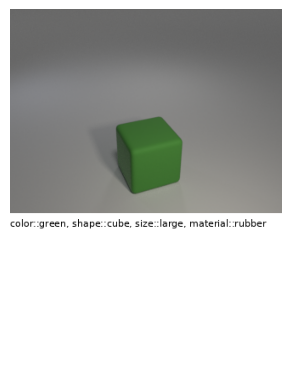

Image with attributes saved to ../Figs/CLEVR/example_454.jpg
Example:


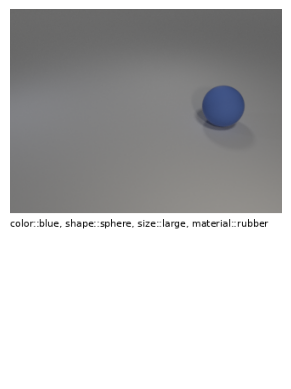

Image with attributes saved to ../Figs/CLEVR/example_531.jpg
Example:


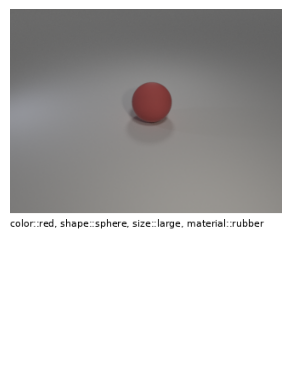

Image with attributes saved to ../Figs/CLEVR/example_573.jpg
Example:


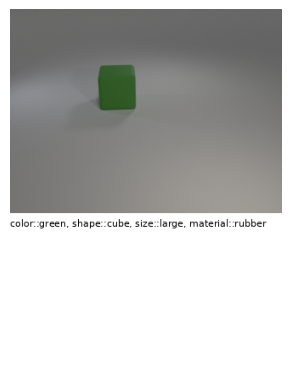

Image with attributes saved to ../Figs/CLEVR/example_38.jpg
Example:


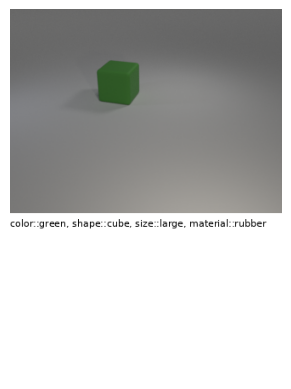

Image with attributes saved to ../Figs/CLEVR/example_752.jpg
Example:


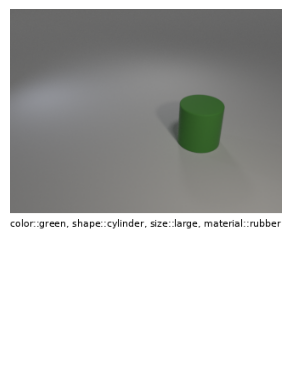

Image with attributes saved to ../Figs/CLEVR/example_894.jpg
Example:


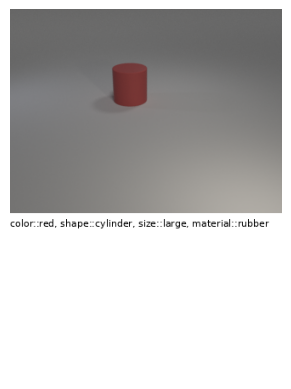

Image with attributes saved to ../Figs/CLEVR/example_912.jpg
Example:


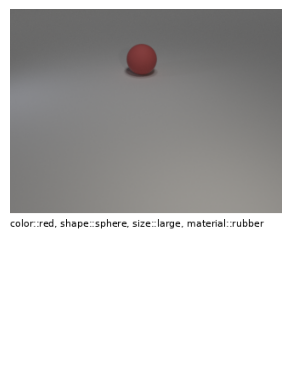

Image with attributes saved to ../Figs/CLEVR/example_893.jpg
Example:


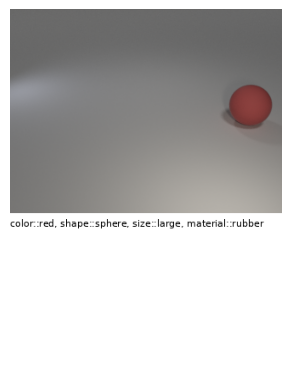

Image with attributes saved to ../Figs/CLEVR/example_586.jpg
Example:


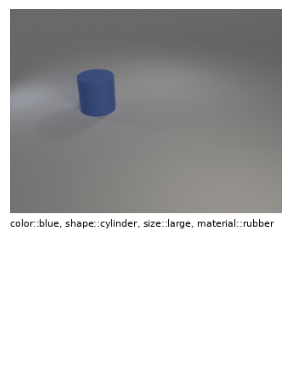

Image with attributes saved to ../Figs/CLEVR/example_686.jpg


In [26]:
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"  # Update with your font path if needed
font = ImageFont.truetype(font_path, 11)
    
for _ in range(10):
    i = np.random.randint(len(metadata))
    print("Example:")
    info = metadata.iloc[i]
    attributes = [attr for attr in info.index if ((attr not in ['image_path', 'class', 'split']) and (info.loc[attr] == 1))]

    image_path = info.loc['image_path']
    img = Image.open(f'../Data/{dataset_name}/{image_path}')

    # Create a new image with extra space at the bottom to accommodate the text
    text_height = 13 # Adjust the height of the text area
    new_img = Image.new('RGB', (img.width, img.height + text_height * 15), color=(255, 255, 255))  # Added extra space for multiple lines
    new_img.paste(img, (0, 0))

    draw = ImageDraw.Draw(new_img)
    #font = ImageFont.load_default()

    # Prepare the text string with attributes separated by commas
    attribute_text = ', '.join(attributes)

    # Wrap the text if it's too wide
    max_width = img.width   # Keep some padding from the edge
    words = attribute_text.split(', ')
    lines = []
    current_line = ""
    for word in words:
        test_line = f"{current_line}, {word}" if current_line else word
        test_bbox = draw.textbbox((0, 0), test_line, font=font)
        test_width = test_bbox[2] - test_bbox[0]
        if test_width <= max_width:
            current_line = test_line
        else:
            lines.append(current_line + ",")  # Add comma at the end of each line
            current_line = word
    lines.append(current_line)  # No comma at the end of the last line

    # Draw the text on the new image, below the original image
    y_offset = img.height + 5  # Start a little below the image
    for line in lines:
        draw.text((0, y_offset), line, font=font, fill="black")
        y_offset += text_height  # Move down for the next line of text

    # Show the image with the attributes underneath it
    plt.imshow(new_img)
    plt.axis('off')
    plt.show()

    # Save the new image with attributes underneath
    output_image_path = f'../Figs/{dataset_name}/example_{i}.jpg'
    new_img.save(output_image_path, dpi=(500, 500))
    print(f"Image with attributes saved to {output_image_path}")


## Example of Text

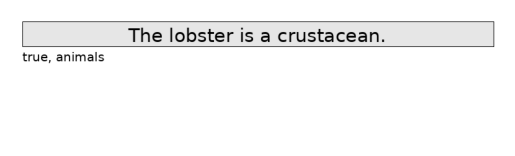

Image with attributes saved to ../Figs/true-false-dataset/example_21.jpg


In [38]:
for _ in range(1):
    i = np.random.randint(len(metadata))
    i = 21
    info = metadata.iloc[i]
    attributes = [attr for attr in info.index if ((attr not in ['class', 'split']) and (info.loc[attr] == 1))]
    
    if 'true' not in attributes:
        attributes.insert(0, 'false')

    text = info.loc['statement']

    # Set up font size and image properties
    font_size = 30  # Larger font size
    text_height = font_size + 10  # Space for text and attributes
    image_width = 800  # Width of the image
    image_height = text_height * (len(attributes) + 1) + 100  # Height for the text and space for attributes
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"  # Update with your font path if needed
    font = ImageFont.truetype(font_path, font_size)
    attribute_font = ImageFont.truetype(font_path, 20)

    # Create a new image with white background
    img = Image.new('RGB', (image_width, image_height), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    # Draw the box for the top text
    box_margin = 20
    box_padding = 5
    draw.rectangle([box_margin, box_margin, image_width - box_margin, text_height + box_margin], fill=(230, 230, 230), outline=(0, 0, 0))

    # Calculate the width of the text and center it within the box using textbbox
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_x = (image_width - text_width) // 2  # Horizontal center
    text_y = box_margin + box_padding  # Vertical position inside the box

    # Draw the centered text
    draw.text((text_x, text_y), text, font=font, fill="black")

    # Prepare the attribute text as a single string and wrap it if necessary
    attribute_text = ', '.join(attributes)
    max_width = image_width - 2 * box_margin  # Keep padding from the edge

    # Wrap the attribute text if it's too wide
    words = attribute_text.split(', ')
    lines = []
    current_line = ""
    for word in words:
        test_line = f"{current_line}, {word}" if current_line else word
        test_bbox = draw.textbbox((0, 0), test_line, font=font)
        test_width = test_bbox[2] - test_bbox[0]
        if test_width <= max_width:
            current_line = test_line
        else:
            lines.append(current_line + ",")  # Add comma at the end of each line
            current_line = word
    lines.append(current_line)  # No comma at the end of the last line

    # Draw the wrapped attribute text below the top text
    y_offset = text_height + box_margin + 5  # Position for the first attribute text
    for line in lines:
        draw.text((box_margin, y_offset), line, font=attribute_font, fill="black")
        y_offset += text_height  # Move down for the next line

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Save the new image with attributes underneath
    output_image_path = f'../Figs/{dataset_name}/example_{i}.jpg'
    img.save(output_image_path, dpi=(500, 500))
    print(f"Image with attributes saved to {output_image_path}")